### 4.1_Yapay Sinir Ağları Uygulaması

In [3]:
"""
Problem tanimi: mnist ver  seti ile rakam siniflandırma projesi 

Ann: yapay sinir aglari
"""

'\nProblem tanimi: mnist ver  seti ile rakam siniflandırma projesi \n\nAnn: yapay sinir aglari\n'

#### 4.2 Veri seti Hazırlama

In [4]:
# !pip install torchvision
import torch # tensor/matrix islemleri
import torch.nn as nn # yapay sinir agi katmanlarini 
import torch.optim as optim # optimizasyon algoritmalarını iceren modul 
import torchvision # goruntu isleme ve pre-defined modelleri icerir
import torchvision.transforms as transforms # goruntu donusumleri yapmak 
import matplotlib.pyplot as plt # gorsellestirme

# optional: cihazi belirle gpu vs cpu 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# veri seti yukleme, data loading 
def get_data_loaders(batch_size = 64): #her iterasyonda istencek veri miktarı, batch size 
    transform = transforms.Compose([
        transforms.ToTensor(), # goruntuyu tensore cevirir ve 0-255 -> 0-1 olceklendir
        transforms.Normalize((0.5,),(0.5,)) # piksel degerlerini -1 ile 1 arasına olcekler 
    ])

    # mnist veri setini indir ve egitim test kumelerini olustur
    train_set = torchvision.datasets.MNIST(root = "./data", train = True, download = True, transform = transform)
    test_set = torchvision.datasets.MNIST(root = "./data", train = False, download = True, transform = transform)

    # pytorch veri yukleyicisini olustur 
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle= True )
    test_loader  = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle= False )

    return train_loader, test_loader

# train_loader, test_loader = get_data_loaders()  # test için yazılmıstır , en aşagıda baglanmıstır

#### 4.3 Veri Görsellestirme

In [ ]:
# data visualization 
def visualize_samples(loader, n):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(1, n, figsize = (10,5)) # n farkli goruntu icin görsellestirme
    for i in range(n):
        axes[i].imshow(images[i].squeeze(), cmap = "gray")
        axes[i].set_title(f"label:{labels[i].item()}")
        axes[i].axis("off")
    plt.show()
    
# visualize_samples(train_loader, 4) # test için yazılmıstır , en aşagıda baglanmıstır

#### 4.4 Modelin Oluşturulması 

In [ ]:
# define ann model 

class NeuralNetwork(nn.Module): # pytorch un nn.module sinifindan miras aliyor 
    def __init__(self): # nn insa etmek icin gerekli olan bilesenleri tanimla  
        super(NeuralNetwork, self).__init__()
        
        self.flatten = nn.Flatten() # elimizde bulunan goruntuleri (2D) vektor haline cevirelim (1D) 28*28 = 784
        
        self.fc1  = nn.Linear(28*28, 128) # ilk bagli katmani olustur: 784 = input size, 128 = output size
        
        self.relu = nn.ReLU() # aktivasyon fonksiyonu olustur
        
        self.fc2  = nn.Linear(128,64) # ikinci tam bagli katmani olustur
        
        self.fc3  = nn.Linear(64, 10) # cikti katmani olustur : 64 = input size, 10 = output size (0-9 etiketleri)
    
    def forward(self, x): # forard propagation: ileri yayilim, giris olarak x = goruntu alsin
        
        x = self.flatten(x) # initial x = 28*28 lik bir goruntu - duzlestir 784 vektor haline getir 
        x = self.fc1(x)  # birinci bagli katman
        x = self.relu(x) # aktivasyon fonk
        x = self.fc2(x)  # ikinci bagli katman
        x = self.relu(x) # aktivasyon fonk
        x = self.fc3(x)  # output katmani
        
        return x #modelimizin ciktisini return eder

# create model and compile
model = NeuralNetwork().to(device)

# kayip fonksiyonu ve optimizasyon algoritmasıni belirle 
define_loss_and_optimizer = lambda model: (
    nn.CrossEntropyLoss(), # multi class classification problems loss func
    optim.Adam(model.parameters(), lr = 0.001) # update weights with adam
)

# criterion, optimizer = define_loss_and_optimizer(model) # test için yazılmıstır , en aşagıda baglanmıstır

#### 4.5 Modelin Egitilmesi

In [ ]:
# train
def train_model(model, train_loader, criterion, optimizer, epochs = 10):
    model.train() # modelimizi egitim moduna alalim 
    train_losses= []

    for epoch in range (epochs):
        total_loss = 0 # toplam kayıp degeri

        for images, labels in train_loader: # tum egitim verilri uzerıde iterasyon gerceklesır 
            images, labels = images.to(device), labels.to(device) # verileri cihaza bagla 
            optimizer.zero_grad() # gradyanlari sifirla
            predictions = model(images) # modeli uygula, foward pro. 
            loss = criterion(predictions, labels) # loss hesaplama -> y_pred ile y_test 
            loss.backward() # geri yayilim yani gradyan hesaplama 
            optimizer.step() # update weights 

            total_loss = total_loss + loss.item()

        avg_loss = total_loss / len(train_loader) # ort kayip hesaplama
        train_losses.append(avg_loss)
        print ( f"epoch: {epoch+1}/{epochs}, Loss: {avg_loss: .3f}")
    
    plt.figure()
    plt.plot(range(1,epochs + 1), train_losses, marker = "o", linestyle = "-", label = "Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.show()

# train_model(model, train_loader, criterion, optimizer, epochs = 1) # test için yazılmıstır, en aşagıda baglanmıstır

#### 4.6 Modelin Test Edilmesi 

In [8]:
def test_model(model, test_loader):
    model.eval() # modelimzi degerlendirme moduna al 
    correct = 0 # dogru tahmin sayaci 
    total = 0 # topla veri sayaci 

    with torch.no_grad(): # gradyan hesalaması gereksiz oldugundan kapattik 
        for images, labels in test_loader: # test veri kumesini oguye al
            images, labels = images.to(device), labels.to(device)
            predictions = model(images)
            _, predicted = torch.max(predictions, 1) # en yuksek olasılıklı sınıfın etiketini bul 

            total += labels.size(0) # toplam veri sayisini gucelle 
            correct += (predicted == labels).sum().item() # dogru tahminleri say 

    print(f"test acc : {100*correct/total:}% ")

# test_model(model, test_loader) # test için yazılmıstır, en aşagıda baglanmıstır

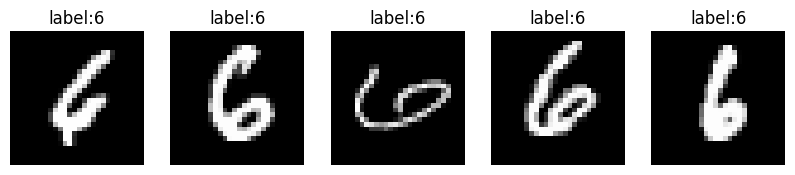

epoch: 1/10, Loss:  0.396
epoch: 2/10, Loss:  0.194
epoch: 3/10, Loss:  0.143
epoch: 4/10, Loss:  0.111
epoch: 5/10, Loss:  0.096
epoch: 6/10, Loss:  0.085
epoch: 7/10, Loss:  0.076
epoch: 8/10, Loss:  0.068
epoch: 9/10, Loss:  0.061
epoch: 10/10, Loss:  0.056


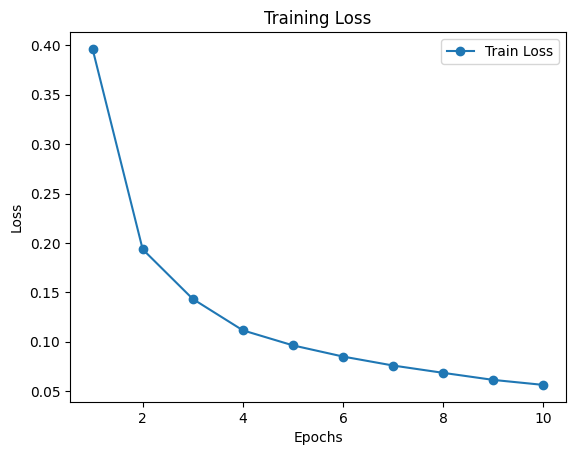

test acc : 97.53% 


In [9]:
# main 
if __name__ == "__main__":
    train_loader, test_loader = get_data_loaders() # veri yukleyicilerini al
    visualize_samples(train_loader, 5) 
    model = NeuralNetwork().to(device)
    criterion, optimizer = define_loss_and_optimizer(model)
    train_model(model, train_loader, criterion, optimizer)
    test_model(model, test_loader)